In [91]:
import json
import numpy as np
import random
import time
from math import sqrt
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

In [25]:
f = open("/Users/Marc/Downloads/squad1.1/train-v1.1.json")
f_test = open("/Users/Marc/Downloads/squad1.1/dev-v1.1.json")
data = json.load(f)
data_train = random.sample(data['data'], 100) # Training dataset
data_test = json.load(f_test)['data'] # Test dataset

In [86]:
def create_embeddings(model, questions, contexts):   
    return (model.encode(questions[:,0]), model.encode(contexts))

def mean_accuracy(model,questions, contexts):
    t=time.time()
    N_questions=len(questions)
    questions_emb, contexts_emb  = create_embeddings(model, questions, contexts)
    #print(time.time()-t)
    if model == model_msmarco:
        score_function = util.dot_score
    else:
        score_function = util.pytorch_cos_sim
    
    predictions = util.semantic_search(questions_emb,
                     contexts_emb,
                     top_k = 1,
                     query_chunk_size = 100000,
                     score_function = score_function)
    
    #print(time.time()-t)
    inc = 0
    idx = 0
    for res in predictions:
        inc+=int(res[0]['corpus_id'] == int(questions[idx,1]))
        idx+=1
    mean_accuracy = inc/N_questions
    return [mean_accuracy, time.time() - t]

def n_1st_mean_accuracy(model,questions, questions_emb, contexts_emb, n):
    t=time.time()
    N_questions=len(questions_emb)
    #print(N_questions)
    #print(time.time()-t)
    if model == model_msmarco:
        score_function = util.dot_score
    else:
        score_function = util.pytorch_cos_sim
    
    predictions = util.semantic_search(questions_emb,
                     contexts_emb,
                     top_k = n,
                     query_chunk_size = 100000)
    
    #print(time.time()-t)
    inc = 0
    idx = 0
   # print(predictions)
    for res in predictions:
      #  print(res)
        ctx_ids = []
        for ctx in res:
           # print(ctx)
            ctx_ids.append(ctx['corpus_id'])
           # print(ctx_ids)
            #print(questions[idx,1])
        inc+=int(questions[idx][1] in ctx_ids)
        idx+=1
    mean_accuracy = inc/N_questions
    return [mean_accuracy, time.time() - t]

# Optimisation on the Squad training data

In [17]:
N_thm = len(data_train)
C_train = [] # List of training contexts
Q_train = [] # List of training questions and corresponding contexts indicies
n_ctx = 0
for thm in range(N_thm):
    for ctx in range(len(data_train[thm]['paragraphs'])):
        C_train.append(data_train[thm]['paragraphs'][ctx]['context'])
        for qst in range(len(data_train[thm]['paragraphs'][ctx]['qas'])):  
            Q_train.append([data_train[thm]['paragraphs'][ctx]['qas'][qst]['question'], n_ctx])
        n_ctx+=1
Q_train_arr = np.array(Q_train)

In [9]:
model_msmarco = SentenceTransformer('msmarco-distilbert-base-tas-b')
model_msmarco_cos = SentenceTransformer('msmarco-distilbert-base-v4')
model_all = SentenceTransformer('all-mpnet-base-v2')
model_mini = SentenceTransformer('all-MiniLM-L12-v2')
models = [model_msmarco,model_msmarco_cos,model_all, model_mini]

In [18]:
mean_accuracies = []
for model in models:
    mean_accuracies = mean_accuracies + [mean_accuracy(model, Q_train_arr, C_train)]

2175.803215742111
2178.616759777069
1638.958431005478
1641.8544561862946
3556.789417028427
3559.072776079178
787.9021167755127
792.8327009677887


In [19]:
mean_accuracies

[[0.6696856686201386, 2178.710517883301],
 [0.5651668523272146, 1641.9281451702118],
 [0.6830047948854555, 3559.1809120178223],
 [0.6410132222598924, 792.9442980289459]]

In [21]:
mean_accuracies_arr= np.array(mean_accuracies)

In [20]:
np.shape(Q_train_arr)

(20647, 2)

In [23]:
2*mean_accuracies_arr[:,0]**2/sqrt(np.shape(Q_train_arr)[0])

array([0.00624228, 0.00444585, 0.00649305, 0.0057192 ])

# Test on the Squad test data

In [26]:
N_thm_test = len(data_test)
C_test = [] # List of test contexts
Q_test = [] # List of test questions and corresponding contexts indicies
n_ctx = 0
for thm in range(N_thm_test):
    for ctx in range(len(data_test[thm]['paragraphs'])):
        C_test.append(data_test[thm]['paragraphs'][ctx]['context'])
        for qst in range(len(data_test[thm]['paragraphs'][ctx]['qas'])):  
            Q_test.append([data_test[thm]['paragraphs'][ctx]['qas'][qst]['question'], n_ctx])
        n_ctx+=1
Q_test_arr = np.array(Q_test)

In [29]:
test_accuracy = mean_accuracy(model_all)

2179.7432658672333
2180.373449087143


In [31]:
test_accuracy

[0.6545884578997162, 2180.4102759361267]

In [61]:
Q_test_embedded = model_all.encode(Q_test_arr[:,0])
C_test_embedded = model_all.encode(C_test)

In [110]:
Nth = np.arange(1,16)
Nth_test_accuracies = []
for n in Nth:
    Nth_test_accuracies.append(n_1st_mean_accuracy(model_all, Q_test, Q_test_embedded, C_test_embedded, n))

In [111]:
Nth_test_accuracies_arr = np.array(Nth_test_accuracies)

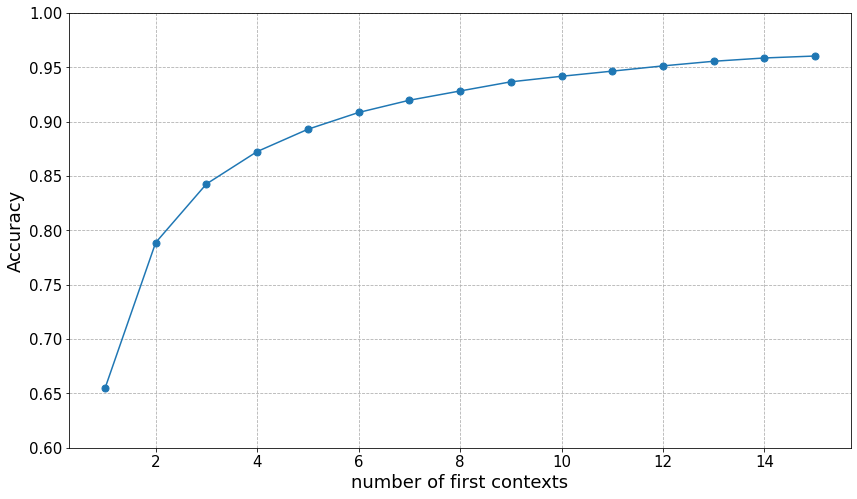

In [114]:
plt.figure(figsize=(14, 8))
plt.xlabel('number of first contexts', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylim((0.6,1))
plt.plot(Nth, Nth_test_accuracies_arr[:,0],'-o'
         ,markersize=7)

plt.grid(linestyle='--')
plt.savefig("Acc_nctx.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Module livrable

In [91]:
import json
import numpy as np
import random
import time
from math import sqrt
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

In [25]:
f_test = open("/Users/Marc/Downloads/squad1.1/dev-v1.1.json")
data_test = json.load(f_test)['data'] # Test dataset

In [26]:
N_thm_test = len(data_test)
C_test = [] # List of test contexts
Q_test = [] # List of test questions and corresponding contexts indicies
n_ctx = 0
for thm in range(N_thm_test):
    for ctx in range(len(data_test[thm]['paragraphs'])):
        C_test.append(data_test[thm]['paragraphs'][ctx]['context'])
        for qst in range(len(data_test[thm]['paragraphs'][ctx]['qas'])):  
            Q_test.append([data_test[thm]['paragraphs'][ctx]['qas'][qst]['question'], n_ctx])
        n_ctx+=1
Q_test_arr = np.array(Q_test)

In [ ]:
C_test_embedded = model_all.encode(C_test) # Embedded list of contexts

In [60]:
def find_context(question, contexts=C_test, contexts_emb=C_test_embedded):
    question_emb = model_all.encode(question)
    prediction = util.semantic_search(question_emb,
                     contexts_emb,
                     top_k = 1,
                     query_chunk_size = 100000)
    context_id = int(prediction[0][0]['corpus_id'])
    return contexts[context_id]

In [121]:
# Example
t = time.time()
print(find_context("When did Nikola Tesla die?", C_test, C_test_embedded))
print("\ntime elapsed:",time.time()-t,"sec")

Nikola Tesla (Serbian Cyrillic: Никола Тесла; 10 July 1856 – 7 January 1943) was a Serbian American inventor, electrical engineer, mechanical engineer, physicist, and futurist best known for his contributions to the design of the modern alternating current (AC) electricity supply system.

time elapsed: 0.11606216430664062 sec
